In [2]:
import warnings
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

warnings.simplefilter("ignore")
%matplotlib inline

print(os.listdir("../input"))

['test.csv', 'test', 'sample_submission', 'train', 'train.csv', 'sample_submission.csv']


# Load the training dataset

In [3]:
df_train = pd.read_csv(os.path.join('..', 'input', 'train.csv'), index_col=0)

# Explore the training dataset

## Print row and types

In [4]:
df_train.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
id,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
df_train.dtypes

vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

## Check and remove duplicated rows

In [6]:
df_train.duplicated().sum()

7

There is 7 duplicated rows, let's remove them

In [7]:
df_train = df_train.drop_duplicates()
df_train.duplicated().sum()

0

## Check for null values

In [8]:
df_train.isna().sum()

vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

## Check for outliers

First let's describe the dataframe with pretty printed columns

In [9]:
describe = df_train.describe()

def seconds_to_pretty(seconds):
    seconds = int(float(seconds))
    return '{} h {} m {} s ({} s)'.format(seconds // 3600, (seconds % 3600) // 60, (seconds % 3600) % 60, seconds)

describe = describe.drop('count') # to disable scientific notation
describe['trip_duration'] = describe['trip_duration'].apply(str)
describe['trip_duration'].loc[['mean', 'min', '25%', '50%', '75%', 'max']] = describe['trip_duration'].loc[['mean', 'min', '25%', '50%', '75%', 'max']].apply(seconds_to_pretty)
describe

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
mean,1.534948,1.664525,-73.973486,40.750921,-73.973416,40.751800,0 h 15 m 59 s (959 s)
std,0.498777,1.314242,0.070902,0.032881,0.070643,0.035891,5236.969980782912
min,1.000000,0.000000,-121.933342,34.359695,-121.933304,32.181141,0 h 0 m 1 s (1 s)
25%,1.000000,1.000000,-73.991867,40.737347,-73.991325,40.735886,0 h 6 m 37 s (397 s)
50%,2.000000,1.000000,-73.981743,40.754101,-73.979752,40.754524,0 h 11 m 2 s (662 s)
75%,2.000000,2.000000,-73.967331,40.768360,-73.963013,40.769810,0 h 17 m 55 s (1075 s)
max,2.000000,9.000000,-61.335529,51.881084,-61.335529,43.921028,979 h 31 m 22 s (3526282 s)


We can see here that some values seem to be outliers:
* max trip_duration seems a way too long
* min trip_duration seems too short
* min passenger_count is 0

In [10]:
# def pretty_print_max_trip_duration(df):   
#     max_trip_duration = df_train['trip_duration'].max()
#     print('Max duration trip: ({} sec) -> {} hours {} minutes {} secondes'.format(max_trip_duration, max_trip_duration // 3600, (max_trip_duration % 3600) // 60, (max_trip_duration % 3600) % 60))

# pretty_print_max_trip_duration(df_train)

let's make a boxplot to better outliers visualization

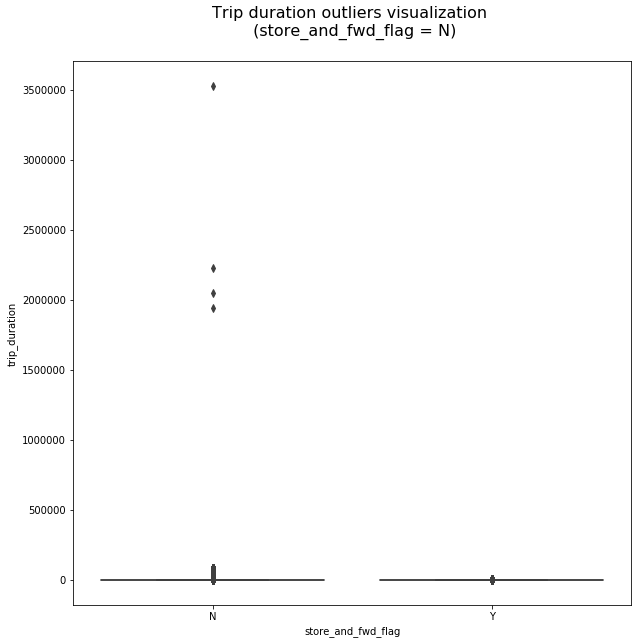

In [11]:
# let's make a boxplot to better trip_duration outliers visualization
# we need to see if there is any correlation between trip_duration and store_and_fwd_flag
def boxplot_trip_duration(df, ylim=None):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    plt.subplots_adjust(wspace=1)
    if ylim:
        ax.set_ylim(ylim)
    sns.boxplot(data=df_train, y='trip_duration', x='store_and_fwd_flag', fliersize=5, ax=ax).axes.set_title(label='Trip duration outliers visualization \n (store_and_fwd_flag = N)', fontsize=16, pad=25)
#     sns.boxplot(y=df_train[df_train['store_and_fwd_flag'] == 'N']['trip_duration'], fliersize=5, ax=ax1).axes.set_title(label='Trip duration outliers visualization \n (store_and_fwd_flag = N)', fontsize=16, pad=25)
#     sns.boxplot(y=df_train[df_train['store_and_fwd_flag'] == 'Y']['trip_duration'], fliersize=5, ax=ax2).axes.set_title(label='Trip duration outliers visualization \n (store_and_fwd_flag = Y)', fontsize=16, pad=25)
    
boxplot_trip_duration(df_train)

The higer trip_duration outliers seem to be present when store_and_fwd_flag = N, this is probably due to the vehicle did not have a connection to the server during a long time

In [12]:
with_n = len(df_train[df_train['store_and_fwd_flag'] == 'N'].index)
with_y = len(df_train[df_train['store_and_fwd_flag'] == 'Y'].index)

len(df_train[df_train['store_and_fwd_flag'] == 'N'].index), len(df_train[df_train['store_and_fwd_flag'] == 'Y'].index)

(1450592, 8045)

There is a majority of rows with store_and_fwd_flag = no, so we can't afford to remove them

In [13]:
seconds_to_pretty(df_train[df_train['store_and_fwd_flag'] == 'N']['trip_duration'].max()), seconds_to_pretty(df_train[df_train['store_and_fwd_flag'] == 'Y']['trip_duration'].max())

('979 h 31 m 22 s (3526282 s)', '2 h 46 m 24 s (9984 s)')

2 h 46 m 24 s may seem long for a trip to New York, but in doubt we will keep it

Let's zoom and the small values

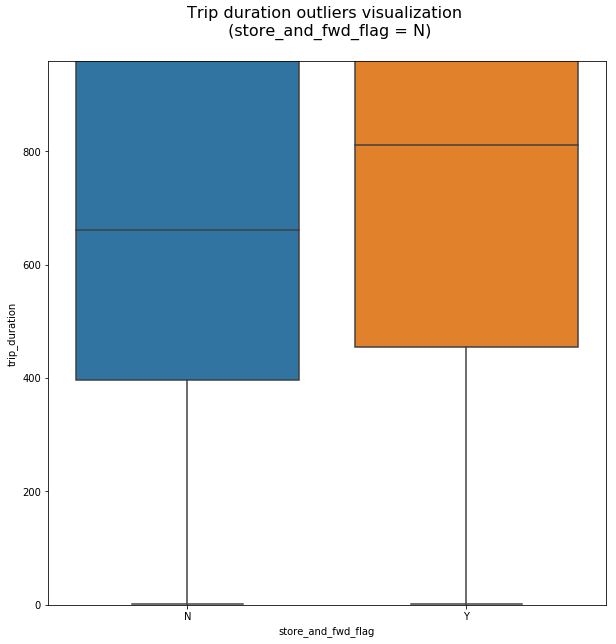

In [14]:
boxplot_trip_duration(df_train, [0, df_train[df_train['store_and_fwd_flag'] == 'N']['trip_duration'].mean()])

So we have to delete the values near 0

Let's see the passenger_count distribution

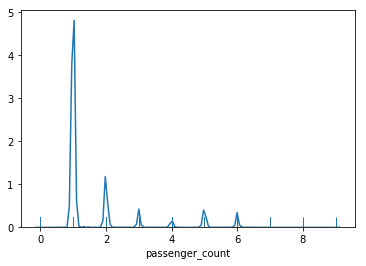

In [15]:
_ = sns.distplot(df_train['passenger_count'], hist=False, rug=True)

There is a majority of trips with 1 passanger

Let's visualize the pickup positions


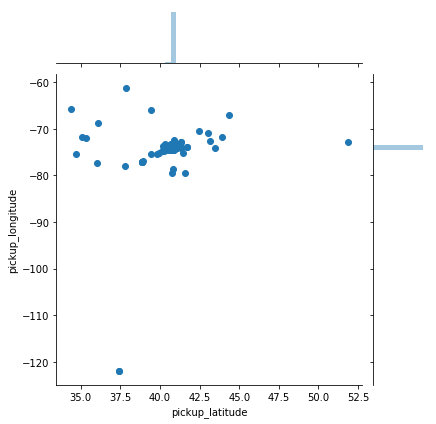

In [16]:
_ = sns.jointplot(data=df_train, x="pickup_latitude", y="pickup_longitude")

Let's visualize the dropoff positions

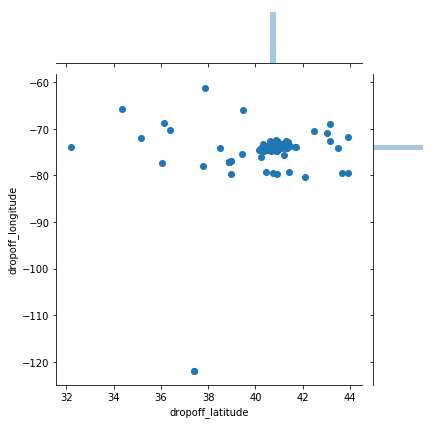

In [17]:
_ = sns.jointplot(data=df_train, x="dropoff_latitude", y="dropoff_longitude")

There is some outilers positions

# Load the test dataset

In [18]:
df_test = pd.read_csv(os.path.join('..', 'input', 'test.csv'), index_col=0)
df_test.head()

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
id,,,,,,,,
id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [19]:
len(df_test.index)

625134

# Compare train and test datasets

In [20]:
df_train.describe().drop('count')

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
mean,1.534948,1.664525,-73.973486,40.750921,-73.973416,40.751800,9.594335e+02
std,0.498777,1.314242,0.070902,0.032881,0.070643,0.035891,5.236970e+03
min,1.000000,0.000000,-121.933342,34.359695,-121.933304,32.181141,1.000000e+00
25%,1.000000,1.000000,-73.991867,40.737347,-73.991325,40.735886,3.970000e+02
50%,2.000000,1.000000,-73.981743,40.754101,-73.979752,40.754524,6.620000e+02
75%,2.000000,2.000000,-73.967331,40.768360,-73.963013,40.769810,1.075000e+03
max,2.000000,9.000000,-61.335529,51.881084,-61.335529,43.921028,3.526282e+06


In [21]:
df_test.describe().drop('count')

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
mean,1.534884,1.661765,-73.973614,40.750927,-73.973458,40.751816
std,0.498782,1.311293,0.073389,0.029848,0.072565,0.035824
min,1.000000,0.000000,-121.933128,37.389587,-121.933327,36.601322
25%,1.000000,1.000000,-73.991852,40.737392,-73.991318,40.736000
50%,2.000000,1.000000,-73.981743,40.754093,-73.979774,40.754543
75%,2.000000,2.000000,-73.967400,40.768394,-73.963013,40.769852
max,2.000000,9.000000,-69.248917,42.814938,-67.496796,48.857597


Latitudes and longitudes seems pretty similar

passenger_count seems pretty similar too, so we don't need to filter them

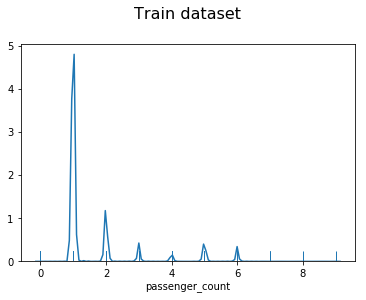

In [22]:
_ = sns.distplot(df_train['passenger_count'], hist=False, rug=True).set_title(label='Train dataset', fontsize=16, pad=25)

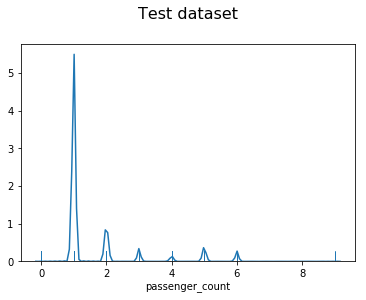

In [23]:
_ = sns.distplot(df_test['passenger_count'], hist=False, rug=True).set_title(label='Test dataset', fontsize=16, pad=25)

Distribution is pretty similar too

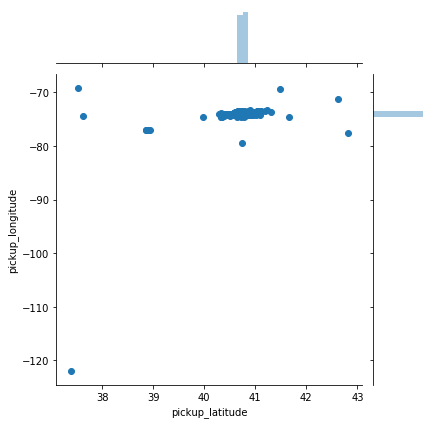

In [24]:
_ = sns.jointplot(data=df_test, x="pickup_latitude", y="pickup_longitude")

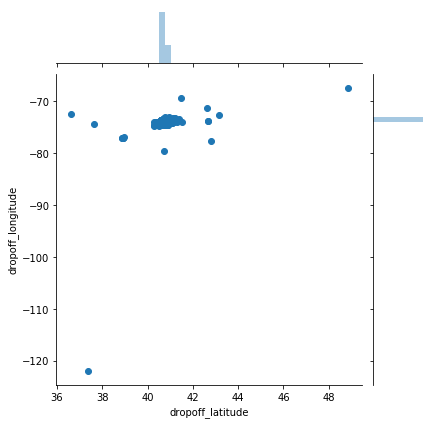

In [25]:
_ = sns.jointplot(data=df_test, x="dropoff_latitude", y="dropoff_longitude")

The test dataset seems to have more extreme coordinates

## Fix outliers

In first, let's delete all the rows with not stored and forwarded trip and trip_duration > max of trip_duration of rows with stored and forwarded trip

In [26]:
max_trip_duration_flag_y = df_train[df_train['store_and_fwd_flag'] == 'Y']['trip_duration'].max()
row_count_before_deletion = len(df_train.index)
print('{} lines before deletion'.format(row_count_before_deletion))
df_train = df_train[~((df_train['store_and_fwd_flag'] == 'N') & (df_train['trip_duration'] > max_trip_duration_flag_y))]
row_count_after_deletion = len(df_train.index)
print('{} lines after deletion'.format(row_count_after_deletion))
print('{} lines deleted'.format(row_count_before_deletion - row_count_after_deletion))

1458637 lines before deletion
1456515 lines after deletion
2122 lines deleted


We have deleted 2122 rows on 1458637 row, that's ok


let's check the outliers visualization now

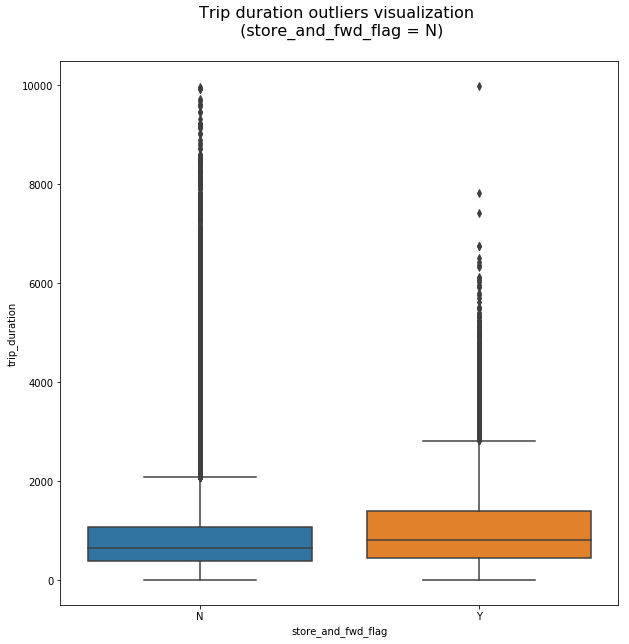

In [27]:
boxplot_trip_duration(df_train)

There seem to be still extreme values on Y column

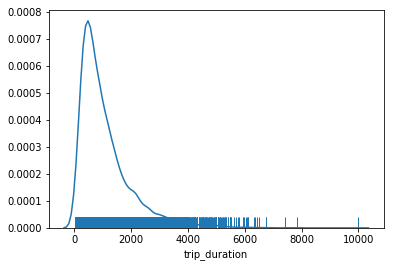

In [28]:
_ = sns.distplot(df_train[df_train['store_and_fwd_flag'] == 'Y']['trip_duration'], hist=False, rug=True)

In [29]:
df_train[((df_train['store_and_fwd_flag'] == 'Y') & (df_train['trip_duration'] > 6500))]['trip_duration'].count()

6

~~I think we need to remove all trip durations > 6500~~, i think this method overfit the model :/

In [30]:
# row_count_before_deletion = len(df_train.index)
# print('{} lines before deletion'.format(row_count_before_deletion))
# df_train = df_train[df_train['trip_duration'] <= 6500]
# row_count_after_deletion = len(df_train.index)
# print('{} lines after deletion'.format(row_count_after_deletion))
# print('{} lines deleted'.format(row_count_before_deletion - row_count_after_deletion))

In [31]:
# _ = sns.distplot(df_train['trip_duration'], hist=False, rug=True)

Ok, we are good for the to long trip durations

1. Now let's remove the trip durations <= 10 sec, a trip duration <= 10 sec makes no sens

In [32]:
row_count_before_deletion = len(df_train.index)
print('{} lines before deletion'.format(row_count_before_deletion))
df_train = df_train[df_train['trip_duration'] >= 10]
row_count_after_deletion = len(df_train.index)
print('{} lines after deletion'.format(row_count_after_deletion))
print('{} lines deleted'.format(row_count_before_deletion - row_count_after_deletion))

1456515 lines before deletion
1454531 lines after deletion
1984 lines deleted


~~Now lets remove trips with passenger_count = 0~~

We dont have to remove passenger_count = 0 because the test dataset have too

In [33]:
# df_train[df_train['passenger_count'] < 1]['passenger_count'].count()

In [34]:
# row_count_before_deletion = len(df_train.index)
# print('{} lines before deletion'.format(row_count_before_deletion))
# df_train = df_train[df_train['passenger_count'] >= 1]
# row_count_after_deletion = len(df_train.index)
# print('{} lines after deletion'.format(row_count_after_deletion))
# print('{} lines deleted'.format(row_count_before_deletion - row_count_after_deletion))

# Scale the train dataset to the test dataset

Determine max and min lat, long from the test dataset

In [35]:
# max_test_pickup_latitude = df_test['pickup_latitude'].max()
# min_test_pickup_latitude = df_test['pickup_latitude'].min()

# max_test_pickup_longitude = df_test['pickup_longitude'].max()
# min_test_pickup_longitude = df_test['pickup_longitude'].min()


# max_test_dropoff_latitude = df_test['dropoff_latitude'].max()
# min_test_dropoff_latitude = df_test['dropoff_latitude'].min()

# max_test_dropoff_longitude = df_test['dropoff_longitude'].max()
# min_test_dropoff_longitude = df_test['dropoff_longitude'].min()

# (max_test_pickup_latitude, min_test_pickup_latitude, '---',
#  max_test_pickup_longitude, min_test_pickup_longitude, '---',
#  max_test_dropoff_latitude, min_test_dropoff_latitude, '---',
#  max_test_dropoff_longitude, min_test_dropoff_longitude)

In [36]:
# row_count_before_deletion = len(df_train.index)
# print('{} lines before deletion'.format(row_count_before_deletion))

# df_train['pickup_latitude'] = df_train[df_train['pickup_latitude'] <= max_test_pickup_latitude]['pickup_latitude']
# df_train['pickup_latitude'] = df_train[df_train['pickup_latitude'] >= min_test_pickup_latitude]['pickup_latitude']

# df_train['pickup_longitude'] = df_train[df_train['pickup_longitude'] <= max_test_pickup_longitude]['pickup_longitude']
# df_train['pickup_longitude'] = df_train[df_train['pickup_longitude'] >= min_test_pickup_longitude]['pickup_longitude']


# df_train['dropoff_latitude'] = df_train[df_train['dropoff_latitude'] <= max_test_dropoff_latitude]['dropoff_latitude']
# df_train['dropoff_latitude'] = df_train[df_train['dropoff_latitude'] >= min_test_dropoff_latitude]['dropoff_latitude']

# df_train['dropoff_longitude'] = df_train[df_train['dropoff_longitude'] <= max_test_dropoff_longitude]['dropoff_longitude']
# df_train['dropoff_longitude'] = df_train[df_train['dropoff_longitude'] >= min_test_dropoff_longitude]['dropoff_longitude']

# row_count_after_deletion = len(df_train.index)
# print('{} lines after deletion'.format(row_count_after_deletion))
# print('{} lines deleted'.format(row_count_before_deletion - row_count_after_deletion))

# Define data manipulation functions and variables

In [37]:
from geopy.distance import geodesic

def create_datetime_based_columns(df):
    df['datetime'] =  pd.to_datetime(df['pickup_datetime'])
    
    df['year'] = df['datetime'].dt.year # year seems to help
    df['month'] = df['datetime'].dt.month # month doesn't help at all
    df['day'] = df['datetime'].dt.day
    df['dayofweek'] = df['datetime'].dt.weekday
    df['hour'] = df['datetime'].dt.hour
    
    return df

# Define filtering/split functions

In [38]:
def filter_feature_columns(df):
    selected_columns = []
    selected_columns = ['pickup_longitude', 'pickup_latitude'] 
    selected_columns += ['dropoff_longitude', 'dropoff_latitude']
    selected_columns += ['month', 'dayofweek', 'hour']
#     selected_columns += ['store_and_fwd_flag']
#     selected_columns += ['lat_distance', 'long_distance']
    return df[selected_columns]

def filter_target_column(df):
    return df['trip_duration']
    

def filter_split_dataset(df):
    X = filter_feature_columns(df)
    y = filter_target_column(df)
    
    return X, y
 

# Let's measure loss

In [39]:
df_train_copy = df_train.copy() # we have to work on a copy of df_train to be able to repeat the operations from 0 without having to reload the dataset
df_train_copy = create_datetime_based_columns(df_train_copy)
# tmp_df_train = normalize_store_and_fwd_flag(tmp_df_train)
# df_train_copy = create_distance_column(df_train_copy)

df_train_copy.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,datetime,year,month,day,dayofweek,hour
id,,,,,,,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14 17:24:55,2016,3,14,0,17
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12 00:43:35,2016,6,12,6,0
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19 11:35:24,2016,1,19,1,11
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06 19:32:31,2016,4,6,2,19
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26 13:30:55,2016,3,26,5,13


In [40]:
X_train, y_train = filter_split_dataset(df_train_copy)
X_train.shape, y_train.shape

((1454531, 7), (1454531,))

In [41]:
X_train.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,month,dayofweek,hour
id,,,,,,,
id2875421,-73.982155,40.767937,-73.964630,40.765602,3,0,17
id2377394,-73.980415,40.738564,-73.999481,40.731152,6,6,0
id3858529,-73.979027,40.763939,-74.005333,40.710087,1,1,11
id3504673,-74.010040,40.719971,-74.012268,40.706718,4,2,19
id2181028,-73.973053,40.793209,-73.972923,40.782520,3,5,13


In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import RandomizedSearchCV # test des combinaisons aléatoirent de parametres
from sklearn.model_selection import GridSearchCV # test toutes les combinaisons

Search to obtains the best RandomForestRegressor params

In [43]:
# thi part take to much time, so I comment it
# rfr_gcv = RandomForestRegressor()
# param_distributions = {
#     'n_estimators' = [10, 100, 200, 300]
#     'min_samples_leaf' = [1, 5, 10]
#     'min_samples_split' = [2, 10, 15]
#     'max_depth' = [10, 40, 80, 90]
# }

# rs = GridSearchCV(rfr_gcv, param_distributions, scoring='neg_mean_squared_log_error')
# rs.fit(X_train, y_train)
# rs.best_params_

Lets estimate the score

In [46]:
# rfr = RandomForestRegressor(n_estimators=19, min_samples_leaf=10, 
#                             min_samples_split=15, max_features='auto', max_depth=80, bootstrap=True)

# RandomForestRegressor with best_params
# rfr = RandomForestRegressor(n_estimators=300, min_samples_leaf=10, min_samples_split=15, 
#                             max_features='auto', max_depth=90, bootstrap=True) # that take too long time :/

rfr = RandomForestRegressor(n_estimators=30, min_samples_leaf=10, min_samples_split=15, 
                            max_features='auto', max_depth=90, bootstrap=True)

s_split = ShuffleSplit(n_splits=4, train_size=.12, test_size=.6) # allows to test on less data, so the cross validation takes less time

# I commented this line to improve kernel execution time
# np.sqrt(-cross_val_score(rfr, X_train, y_train, cv=s_split, scoring='neg_mean_squared_log_error', n_jobs=-1)).mean()

## Let's train the model with training values

In [47]:
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=90,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=15,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

## Let's predict the test trip_duration values

In [48]:
df_test_copy = df_test.copy()
df_test_copy = create_datetime_based_columns(df_test_copy)
# tmp_df_test = normalize_store_and_fwd_flag(tmp_df_test)
X_test = filter_feature_columns(df_test_copy)

y_test_pred = rfr.predict(X_test)
# 
submission = pd.DataFrame({'id': df_test.index, 'trip_duration': y_test_pred})
submission.head()

,id,trip_duration
0,id3004672,767.229917
1,id3505355,676.700376
2,id1217141,438.407611
3,id2150126,1087.667316
4,id1598245,379.528492


In [49]:
submission.to_csv('submission.csv', index=False)
!ls

__notebook_source__.ipynb  submission.csv
